# deepctr

In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath('..'))
# ---------------------------------
from time import sleep
import numpy as np
import pandas as pd
import scipy
import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

from hyperopt import hp
from deepctr.models import DeepFM
from deepctr.inputs import  SparseFeat, DenseFeat, get_feature_names
# ---------------------------------
from tools import CV, Tuning, CVGetScore, IdxValEncoder, LE, CyclicLR, MaxLrFinder
# ---------------------------------
from tools import focal_loss, gelu, mish
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({'focal_loss': focal_loss()})
get_custom_objects().update({'mish': mish})
get_custom_objects().update({'gelu': gelu})

In [2]:
train_df = pd.read_csv('../data/train.csv', index_col='id')
test_df = pd.read_csv('../data/test.csv', index_col='id')

# ord_5
for i in range(2):
    train_df[f'ord_5_{i}'] = train_df['ord_5'].str[i]
    test_df[f'ord_5_{i}'] = test_df['ord_5'].str[i]

# null
train_df['null'] = train_df.isna().sum(axis=1)
test_df['null'] = test_df.isna().sum(axis=1)

for col in test_df.columns:
    train_df[col].fillna('isnull', inplace=True)
    test_df[col].fillna('isnull', inplace=True)

# target
target = train_df['target']
y_train = target.values

# drop
train_df.drop(['target', 'ord_5'], axis=1, inplace=True)
test_df.drop(['ord_5'], axis=1, inplace=True)

In [3]:
feature_col = train_df.columns

bin_col = ['null']

class_col = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4',
             'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4',
             'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
             'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4',
             'day', 'month', 'ord_5_0', 'ord_5_1']

In [4]:
ecd = LE(feature_col, bin_col=bin_col, class_col=class_col)

ecd.fit(train_df, verbose=1)
ecd.fit(test_df, verbose=1)

x_train_arr = ecd.transform(train_df, verbose=1)
x_test_arr = ecd.transform(test_df, verbose=1)

del train_df, test_df

600000it [00:10, 54624.79it/s]
400000it [00:07, 54398.44it/s]
600000it [00:10, 55753.44it/s]
400000it [00:07, 54885.44it/s]


In [5]:
# x_train_df = pd.DataFrame(data=x_train_arr, columns=feature_col)
# x_test_df = pd.DataFrame(data=x_test_arr, columns=feature_col)

In [6]:
def col(vocabulary, sparse_features, dense_features, k=5):
    # sparse
    feature_col = list()
    for f in sparse_features:
        feature_col.append(SparseFeat(f, vocabulary_size=vocabulary[f], embedding_dim=k))
    for f in dense_features:
        feature_col.append(DenseFeat(f, 1))

    dnn_f = feature_col
    linear_f= feature_col
    fn = get_feature_names(linear_f + dnn_f)
    return dnn_f, linear_f, fn

In [9]:
def deepfm(vocabulary, k, loss, metrics, optimizer, 
           num_deep_layer=2, num_neuron=128, **kwargs):
    
    dnn_f, linear_f, _ = col(vocabulary, sparse_features=class_col, dense_features=bin_col, k=k)
    model = DeepFM(linear_feature_columns=linear_f,
                   dnn_feature_columns=dnn_f, 
                   dnn_hidden_units=tuple(num_neuron for _ in range(num_deep_layer)), **kwargs)
    model.compile(loss=loss, metrics=metrics, optimizer=optimizer)
    return model

In [10]:
def mkinput(input_arr, feature_col):
    return dict(zip(feature_col, input_arr.T))

# Search Max LR

In [52]:
%%time
%matplotlib inline

batch_size = 1024
epochs = 5
nflold = 5

model_param = {}

mf = MaxLrFinder(1e-5, 1e-1, epochs=epochs, batch_size=batch_size, sample_length=len(x_train_arr)*((nflold-1)/nflold))
fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[mf]}

model = deepfm(vocabulary=ecd.get_vocabulary(),
               k=5,
               loss='binary_crossentropy',
               metrics=['AUC'], 
               optimizer='Adam',
               num_deep_layer=2, 
               num_neuron=128,
               l2_reg_linear=1e-5,
               l2_reg_embedding=1e-5,
               dnn_dropout=0,
               dnn_activation='relu', 
               dnn_use_bn=False)

cv = CV(model, nflold)

score = cv.fit(x=mkinput(x_train_arr, feature_col),
               y=y_train, 
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               fit_params=fit_param,
               eval_param={'batch_size': batch_size},
               use_proba=False, 
               verbose=True,
               fit_use_valid=True)

tf.keras.backend.clear_session()

Train on 480000 samples, validate on 120000 samples
Epoch 1/5
480000/480000 [==============================] - 15s 32us/sample - loss: 0.9393 - AUC: 0.4991 - val_loss: 0.5298 - val_AUC: 0.5527
Epoch 2/5
480000/480000 [==============================] - 10s 20us/sample - loss: 0.4459 - AUC: 0.6930 - val_loss: 0.3985 - val_AUC: 0.7848
Epoch 3/5
480000/480000 [==============================] - 10s 20us/sample - loss: 0.3976 - AUC: 0.7861 - val_loss: 0.4004 - val_AUC: 0.7816
Epoch 4/5
480000/480000 [==============================] - 10s 21us/sample - loss: 0.4027 - AUC: 0.7801 - val_loss: 0.4105 - val_AUC: 0.7719
Epoch 5/5
480000/480000 [==============================] - 10s 20us/sample - loss: 0.4425 - AUC: 0.7538 - val_loss: 0.5689 - val_AUC: 0.7195
folds 0 is done, score is 0.7195711944338412
Train on 480000 samples, validate on 120000 samples
Epoch 1/5
480000/480000 [==============================] - 15s 31us/sample - loss: 0.7096 - AUC: 0.5069 - val_loss: 0.4702 - val_AUC: 0.6938
Epoch

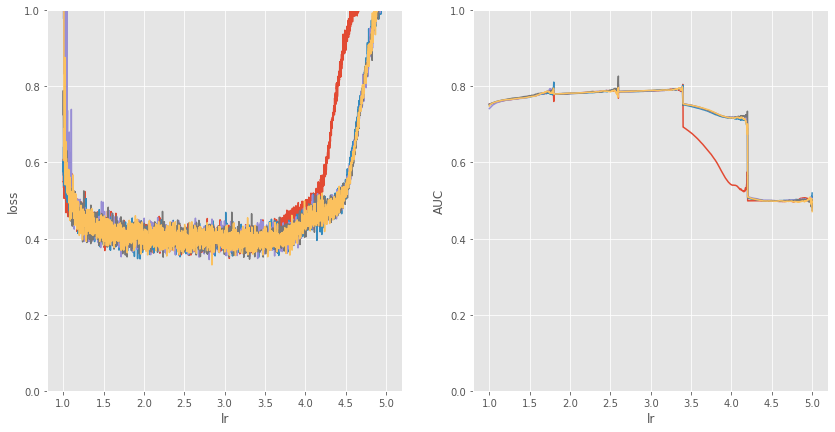

In [53]:
%matplotlib inline
mf.plot(True, [0, 1])

# fit one

In [11]:
! ls ../tmp/deepfm

03051921.csv  1615107092predict.npy  1615107092stacking1.npy


In [12]:
log = pd.read_csv('../tmp/deepfm/03051921.csv')

In [13]:
log.sort_values('score')

,score,update,usetime,deep_activation,deep_dropout,l2_deep,l2_pair,num_neuron
37,-0.788738,True,184.576666,gelu,0.036688,0.000039,0.001919,256
22,-0.788713,True,161.217921,gelu,0.101581,0.000104,0.000939,128
59,-0.788669,False,135.140283,gelu,0.091591,0.000008,0.003207,128
40,-0.788648,False,130.189999,gelu,0.044670,0.000012,0.001696,128
53,-0.788645,False,180.608015,gelu,0.155234,0.000110,0.000710,256
...,...,...,...,...,...,...,...,...
95,-0.787368,False,288.332807,gelu,0.095589,0.000207,0.003818,128
63,-0.787286,False,537.966757,gelu,0.220638,0.000398,0.006345,256
26,-0.787254,False,392.812046,gelu,0.491797,0.000349,0.006370,128
73,-0.787200,False,135.713783,gelu,0.063156,0.000030,0.005777,128


In [15]:
%%time

batch_size = 1024
epochs = 100
nflod = 5

model_param = {'vocabulary': ecd.get_vocabulary(),
               'k':5,
               'loss': 'binary_crossentropy',
               'metrics': ['AUC'], 
               'optimizer': 'Adam',
               'num_deep_layer': 2, 
               'num_neuron': 256,
               'l2_reg_linear': 0.,
               'l2_reg_embedding': 0.001919,
               'l2_reg_dnn': 0.000039,
               'dnn_dropout': 0.036688,
               'dnn_activation': 'gelu', 
               'dnn_use_bn': False}

clr = CyclicLR(base_lr=0.1**(4.5),
               max_lr = 0.1**(4), 
               step_size= int(4.0*(x_train_arr.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='triangular2',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=3, mode='max', restore_best_weights=True)

fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[es, clr]}

model = deepfm(**model_param)

CPU times: user 2.94 s, sys: 296 ms, total: 3.24 s
Wall time: 3.58 s


In [16]:
cv = CV(model, nflod)

score = cv.fit(x=mkinput(x_train_arr, feature_col),
               y=y_train,
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               fit_params=fit_param,
               eval_param={'batch_size':batch_size},
               use_proba=False, 
               verbose=True,
               fit_use_valid=True)

tf.keras.backend.clear_session()

Train on 480000 samples, validate on 120000 samples
Epoch 1/100
480000/480000 [==============================] - 18s 37us/sample - loss: 0.5995 - AUC: 0.5050 - val_loss: 0.4982 - val_AUC: 0.5981
Epoch 2/100
480000/480000 [==============================] - 12s 25us/sample - loss: 0.4765 - AUC: 0.7038 - val_loss: 0.4502 - val_AUC: 0.7640
Epoch 3/100
480000/480000 [==============================] - 12s 25us/sample - loss: 0.4295 - AUC: 0.7709 - val_loss: 0.4202 - val_AUC: 0.7809
Epoch 4/100
480000/480000 [==============================] - 12s 25us/sample - loss: 0.4162 - AUC: 0.7867 - val_loss: 0.4154 - val_AUC: 0.7870
Epoch 5/100
480000/480000 [==============================] - 12s 25us/sample - loss: 0.4115 - AUC: 0.7922 - val_loss: 0.4134 - val_AUC: 0.7885
Epoch 6/100
480000/480000 [==============================] - 12s 26us/sample - loss: 0.4085 - AUC: 0.7951 - val_loss: 0.4123 - val_AUC: 0.7886
Epoch 7/100
480000/480000 [==============================] - 12s 25us/sample - loss: 0.406

In [17]:
score

0.7885763491443407